Having trained a ResNet model, we will evaluate its performance here.

In [1]:
# Change directory to the root of the project
import os 
os.chdir('../../..')
print(f"Working directory: {os.getcwd()}")

Working directory: /Users/eohjelle/Documents/2025-mcts-playground/mcts-playground


In [2]:
# Initialize opponents

from core import OpenSpielState, StandardWinLossTieEvaluator, MCTS, MCTSConfig
import pyspiel

# Initialize state factory

game = pyspiel.load_game("connect_four")
def state_creator():
    return OpenSpielState(game.new_initial_state(), num_players=2)

# Initialize model

from experiments.connect_four.models.resnet import ResNet, ResNetInitParams
from experiments.connect_four.tensor_mapping import LayeredConnectFourTensorMapping
from core import Model, ModelPredictor, AlphaZero, AlphaZeroConfig
import torch

model = Model.from_file(
    model_architecture=ResNet,
    path="experiments/connect_four/resnet_model.pt",
    device=torch.device("cpu")
)
model_predictor = ModelPredictor(model, LayeredConnectFourTensorMapping())
player_creator = lambda state: AlphaZero(state, model_predictor, AlphaZeroConfig(temperature=0.0))

# Initialize opponents

opponents = {f"MCTS_{n}": [lambda state: MCTS(state, MCTSConfig(num_simulations=n))] for n in [0, 25, 50, 100, 200, 400, 800, 1600, 3200]}

evaluator = StandardWinLossTieEvaluator(
    initial_state_creator=state_creator,
    opponents_creators=opponents, # type: ignore
    num_games=100,
)



In [3]:
# Run benchmarks

for opponent, results in evaluator(player_creator).items():
    print(f"{opponent}: {results}")

KeyboardInterrupt: 

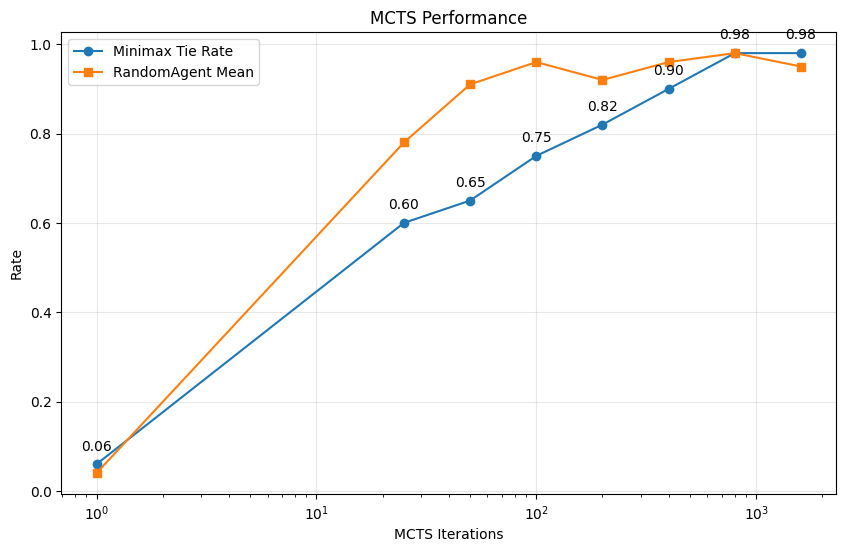

In [ ]:

import matplotlib.pyplot as plt
import numpy as np
from typing import Dict, Any

# Create plot
plt.figure(figsize=(10, 6))
plt.plot(iterations_to_test, minimax_draw_rate, marker='o', label='Minimax Tie Rate')
plt.plot(iterations_to_test, random_score, marker='s', label='RandomAgent Mean')

plt.xscale('log')  # Use log scale for x-axis since iterations vary by orders of magnitude
plt.xlabel('MCTS Iterations')
plt.ylabel('Rate')
plt.title('MCTS Performance')
plt.grid(True, alpha=0.3)
plt.legend()

# Add exact values as annotations
for i, iterations in enumerate(iterations_to_test):
    plt.annotate(f"{minimax_draw_rate[i]:.2f}", 
                (iterations, minimax_draw_rate[i]), 
                textcoords="offset points", 
                xytext=(0,10), 
                ha='center')

# Save plot
plt.savefig('experiments/experimenting_with_model_architectures_in_tic_tac_toe/plots/tic_tac_toe_mcts_benchmark.png')
plt.show()
